<a href="https://colab.research.google.com/github/pahwa1902/Learning/blob/master/LicensePlateDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [46]:
from google.colab import files
files.upload()

Saving [www.olx.jpg to [www.olx.jpg


{'[www.olx.jpg': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01\x00`\x00`\x00\x00\xff\xe1\x00"Exif\x00\x00MM\x00*\x00\x00\x00\x08\x00\x01\x01\x12\x00\x03\x00\x00\x00\x01\x00\x01\x00\x00\x00\x00\x00\x00\xff\xdb\x00C\x00\x02\x01\x01\x02\x01\x01\x02\x02\x02\x02\x02\x02\x02\x02\x03\x05\x03\x03\x03\x03\x03\x06\x04\x04\x03\x05\x07\x06\x07\x07\x07\x06\x07\x07\x08\t\x0b\t\x08\x08\n\x08\x07\x07\n\r\n\n\x0b\x0c\x0c\x0c\x0c\x07\t\x0e\x0f\r\x0c\x0e\x0b\x0c\x0c\x0c\xff\xdb\x00C\x01\x02\x02\x02\x03\x03\x03\x06\x03\x03\x06\x0c\x08\x07\x08\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\xff\xc0\x00\x11\x08\x04\x00\x034\x03\x01"\x00\x02\x11\x01\x03\x11\x01\xff\xc4\x00\x1f\x00\x00\x01\x05\x01\x01\x01\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x01\x02\x03\x04\x05\x06\x07\x08\t\n\x0b\xff\xc4\x00\xb5\x10\x00\x02\x01\x03\x03\x02\x04\x03\x05\x05\x04\x04\x00\

In [1]:
from google.colab.patches import cv2_imshow

In [2]:
import cv2
import numpy as np
import imutils
import matplotlib.pyplot as plt
from PIL import Image
from skimage.segmentation import clear_border

In [3]:
from scipy import ndimage

In [ ]:
!sudo apt install tesseract-ocr
!pip install pytesseract

In [4]:
import pytesseract
import shutil
import os
import random

In [10]:
def plate_pre(image_url,angle,size,image_center):
  image = cv2.imread(image_url)
  image2 = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
  image3 =imutils.resize(image2,width=size[0],height=size[1])
  rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
  image3 = cv2.warpAffine(image3, rot_mat, image3.shape[1::-1], flags=cv2.INTER_LINEAR)
  rectKern = cv2.getStructuringElement(cv2.MORPH_RECT, (13, 5))
  blackhat = cv2.morphologyEx(image3, cv2.MORPH_BLACKHAT, rectKern)
  squareKern = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
  light = cv2.morphologyEx(image3, cv2.MORPH_CLOSE, squareKern)
  light = cv2.threshold(light, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
  gradX = cv2.Sobel(blackhat, ddepth=cv2.CV_32F,dx=1, dy=0, ksize=-1)
  gradX = np.absolute(gradX)
  (minVal, maxVal) = (np.min(gradX), np.max(gradX))
  gradX = 255 * ((gradX - minVal) / (maxVal - minVal))
  gradX = gradX.astype("uint8")
  gradX = cv2.GaussianBlur(gradX, (5, 5), 0)
  gradX = cv2.morphologyEx(gradX, cv2.MORPH_CLOSE, rectKern)
  thresh = cv2.threshold(gradX, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
  thresh = cv2.erode(thresh, None, iterations=2)
  thresh = cv2.dilate(thresh, None, iterations=2)
  thresh = cv2.bitwise_and(thresh, thresh, mask=light)
  thresh = cv2.dilate(thresh, None, iterations=2)
  thresh_data = cv2.erode(thresh, None, iterations=1)
  
  return thresh_data

In [11]:
def gray_image(image_url,angle,size,image_center):
  image = cv2.imread(image_url)
  image2 = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
  img =imutils.resize(image2,width=size[0],height=size[1])
  rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
  gray = cv2.warpAffine(img, rot_mat, img.shape[1::-1], flags=cv2.INTER_LINEAR)
  return gray


In [119]:
def find_contours(plate):
  contours,new = cv2.findContours(plate.copy(),cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)
  contours = sorted(contours,key=cv2.contourArea, reverse=True)[:10]
  license_plate=None
  contour_license_plate = None
  
  h=None
  w=None
  angle1=None
  center1=None
  max=0
  for candidates in contours:
    rect = cv2.minAreaRect(candidates)
    box = cv2.boxPoints(rect)
    box = np.int0(box)
    (x1,y1) = box[0]
    (x2,y2) = box[1]
    (x3,y3) = box[2]
    (x4,y4) = box[3]
    h_1 = np.linalg.norm(np.array((x1,y1))-np.array((x4,y4)))
    w_1 = np.linalg.norm(np.array((x1,y1))-np.array((x2,y2)))
    slope = (y2-y1)/(x2-x1)
    angle = np.arctan(slope)
    
    #(x_1, y_1,w_1, h_1) = cv2.boundingRect(candidates)
    ar = w_1 / float(h_1)
    
    if(ar>max):
      max=ar
      (w,h) = (w_1, h_1)
      (a,b,c,d) = ((x1,y1),(x2,y2),(x3,y3),(x4,y4))
      
      center1 = c
      angle1 = angle
  
  
  return (angle1,w,h,center1,(x1,y1),(x2,y2),(x3,y3),(x4,y4))
   
    


In [96]:
 def right_contours(image_url):
  plate = plate_pre(image_url,0,(360,360),(0,0))
  (w,h) = (int(find_contours(plate)[1]),int(find_contours(plate)[2]))
  
  center = find_contours(plate)[3]
  angle = find_contours(plate)[0]
  img = Image.open(image_url)
  (W,H) = img.size
  
  w1 = w/W
  h1 = h/H
  resize_x = int(60.58/w1)
  resixe_y = int(7.38/h1)
    
  plate2 = plate_pre(image_url,angle,(360,360),center)
  image_gray = gray_image(image_url,angle,(360,360),center)
  (x,y) = center
  
  license_plate2 = image_gray[y:y+h, x:x+w]
  return license_plate2, plate2, image_gray

In [ ]:
plate = right_contours('./yellow_plate.jpg')[1]
image = right_contours('./yellow_plate.jpg')[2]

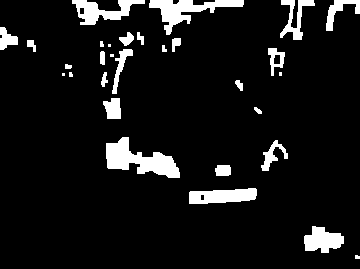

In [87]:
cv2_imshow(plate)

In [89]:
license_plate = right_contours('./yellow_plate.jpg')[0]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: RuntimeWarning: divide by zero encountered in long_scalars


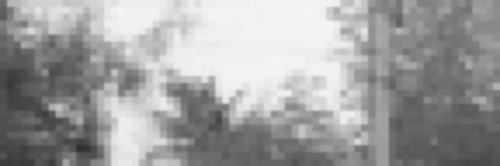

In [90]:

number_plate = imutils.resize(license_plate,width=500,height=300)
number_plate = cv2.GaussianBlur(number_plate,(5,5),0)
#number_plate = cv2.dilate(number_plate,None,iterations=1)
#number_plate = cv2.erode(number_plate,None,iterations=1)



cv2_imshow(number_plate)


In [14]:
license_height, license_width = license_plate.shape

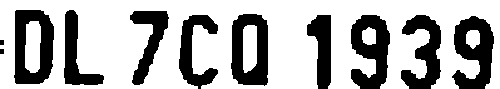

In [83]:

thresh3 = cv2.threshold(number_plate, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
cv2_imshow(thresh3)

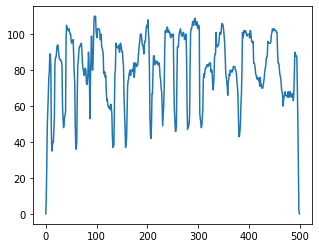

In [108]:
vertical_hist_1 = np.sum(thresh3,axis=0,keepdims=True)/255
vertical_hist_1=vertical_hist_1.reshape(-1,)
plt.figure(figsize=(5,4))
plt.plot(np.array(range(vertical_hist_1.shape[0])),vertical_hist_1)

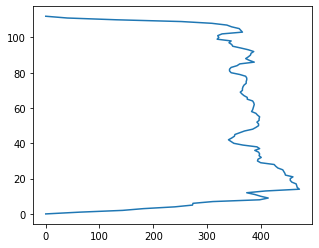

In [109]:
horizontal_hist_1 = np.sum(thresh3,axis=1,keepdims=True)/255
horizontal_hist_1=horizontal_hist_1.reshape(-1,)
plt.figure(figsize=(5,4))
plt.plot(horizontal_hist_1,np.array(range(horizontal_hist_1.shape[0])))

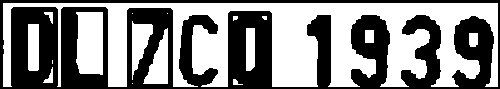

In [85]:
contours_thresh = thresh3.copy()
cnts,her = cv2.findContours(contours_thresh, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
#cnts = cnts[0] if imutils.is_cv2() else cnts[1]
cnt = sorted(cnts, key=cv2.contourArea, reverse=True)[:20]
numbers=[]

for c in cnt:
    (x,y,w,h) = cv2.boundingRect(c)
    character = thresh3[y:y + h, x:x + w]
    numbers.append((x,y,w,h))
    contours_thresh=cv2.rectangle(contours_thresh, (x,y),(x+w,y+h), (0, 0,255), 3)
cv2_imshow(contours_thresh)


In [15]:
alphanumeric = "ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789"
options = "-c tessedit_char_whitelist={}".format(alphanumeric)
options += " --psm {}".format(7)

In [33]:
x1 = int((x*license_width)/900)
y1 = int((y*license_height)/400)
w1 = int((w*license_width)/900)
h1 = int((h*license_height)/400)



In [16]:
numbers

[(1, 1, 276, 79),
 (293, 1, 205, 80),
 (37, 3, 36, 67),
 (233, 6, 35, 67),
 (434, 9, 37, 68),
 (342, 8, 35, 68),
 (387, 9, 37, 67),
 (187, 7, 35, 66),
 (143, 5, 35, 67),
 (83, 4, 35, 67)]

In [17]:
sorted=[]
for i in numbers:
  sorted.append(i[0])

In [18]:
index = np.argsort(sorted)

In [ ]:
number=''
for i in index:
  x,y,w,h = numbers[i]
  char = number_plate[y-4:y+h+4,x-4:x+w+4]
  char = cv2.GaussianBlur(char,(5,5),0)
  text = pytesseract.image_to_string(char,config=options)
  text = text.rstrip()
  print(text)
  number+=str(text)
print(number)

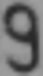

In [106]:
char = number_plate[y-3:y+h+3,x-3:x+w+3]
#char = cv2.dilate(char,None,iterations=2)
char = cv2.GaussianBlur(char,(5,5),0)

cv2_imshow(char)

In [107]:
text = pytesseract.image_to_string(char,config=options)
print(text)

Q



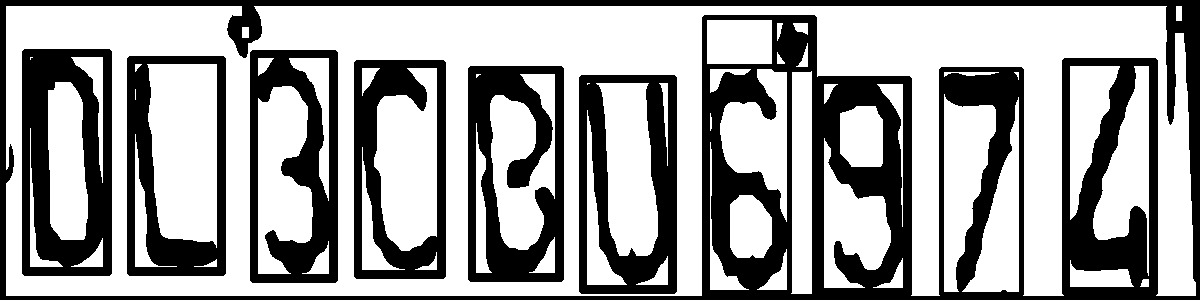

In [261]:
cnts,her = cv2.findContours(thresh3.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
#cnts = cnts[0] if imutils.is_cv2() else cnts[1]
cnts = sorted(cnts, key=cv2.contourArea, reverse=True)[:10]
for cnt in cnts:
  rect = cv2.convexHull(cnt)
  x,y,w,h = cv2.boundingRect(rect)
  thresh3=cv2.rectangle(thresh3, (x,y),(x+w,y+h), (0, 0,255), 3)

cv2_imshow(thresh3)